# CORRELATIONS. Overview

0. [__Importing data__](#0)
    1. [Loading csv files](#0.1)
    2. [Loading shapefiles](#0.2)


1. [__Functions__](#1)
    1. [Temporal evolution](#1.1)    
    2. [Geographical maps](#1.2)


2. [__Fires vs INFOCAT__](#2)
    1. [Geographical maps](#2.1)
    2. [Ratio & correlation](#2.2)  
    3. [Temporal evolution](#2.3)


3. [__Meteorology vs VENTCAT, INUNCAT__](#3)
    1. [Temporal evolution](#3.1)
    2. [Correlation](#3.2)  
    3. [Geographical maps](#3.3)


4. [__Healthcare vs SISMICAT, ALLAUCAT, INUNCAT, VENTCAT, INFOCAT__](#4)

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
from matplotlib.patches import Ellipse
from matplotlib.patches import Circle
import seaborn as sns

In [2]:
font = 14

# 0. Importing data <a class="anchor" id="0"></a>

In [3]:
data_dir = "../dades/"
preprocessed_data_dir = "preprocessed_data/"
fig_dir = "figures/"

## 0.1. Loading csv files <a class="anchor" id="0.1"></a>
We load the CSV files processed and convert the date into a datetime.

In [4]:
protection_plans = pd.read_csv(preprocessed_data_dir+"protection_plans.csv")
inc_112 = pd.read_csv(preprocessed_data_dir+"inc_112.csv")

In [5]:
inc_112['datetime'] = pd.to_datetime(inc_112['datetime'])
protection_plans["Data de l'últim esdeveniment"] = pd.to_datetime(protection_plans["Data de l'últim esdeveniment"])

## 0.2. Loading shapefiles <a class="anchor" id="0.2"></a>
In order to create geographical maps, we nead the SHP files. We import the ones that divide Catalonia into regions, counties and municipalities.

In [6]:
cat_prov = gpd.read_file("cat/provincies/divisions-administratives-v2r1-provincies-100000-20230928.shx")
cat_comar = gpd.read_file("cat/comarques/divisions-administratives-v2r1-comarques-100000-20220801.shx")
cat_muni = gpd.read_file("cat/municipis/divisions-administratives-v2r1-municipis-100000-20230928.shx")


In [7]:
comarques = ["Alt Camp","Alt Empordà","Alt Penedès","Alt Urgell","Alta Ribagorça","Anoia","Aran","Bages","Baix Camp",
             "Baix Ebre","Baix Empordà","Baix Llobregat","Baix Penedès","Barcelonès","Berguedà","Cerdanya",
             "Conca de Barberà","Garraf","Garrigues","Garrotxa","Gironès","Maresme","Moianès","Montsià",
             "Noguera","Osona","Pallars Jussà","Pallars Sobirà","Pla d'Urgell","Pla de l'Estany","Priorat",
             "Ribera d'Ebre","Ripollès","Segarra","Segrià","Selva","Solsonès","Tarragonès","Terra Alta",
             "Urgell","Vallès Occidental","Vallès Oriental"]

# 1. Functions <a class="anchor" id="1"></a>

## 1.1. Temporal evolution <a class="anchor" id="1.1"></a>

In [8]:
def inc_112_temporal_ev(inc_112_df,inc_112_label):
    "Function that generates a dataframe containing the number of incidents per each month registered"
    # inc_112_df: dataframe of the incidents we are interested in
    # inc_112_label: label of the incidents we are interested in for the resulting dataframe
    
    inc_112_df["month"] = inc_112_df['datetime'].dt.month
    inc_112_df["year"] = inc_112_df['datetime'].dt.year

    ninc_time = inc_112_df.groupby(["year","month"])['INCIDENTS'].sum().reset_index(name=inc_112_label)

    ninc_time['datetime'] = pd.to_datetime(ninc_time[['year', 'month']].assign(day=1))

    ninc_time = ninc_time.drop("year",axis=1).drop("month",axis=1)

    return ninc_time

In [9]:
def prot_plans_temporal_ev(prot_plan_df,prot_plan_label):
    "Function that generates a dataframe containing the number of protection plans per each month registered"
    # prot_plan_df: dataframe of the protection plans we are interested in
    # prot_plan_label: label of the protection plans we are interested in for the resulting dataframe
    
    prot_plan_df["month"] = prot_plan_df["Data de l'últim esdeveniment"].dt.month
    prot_plan_df["year"] = prot_plan_df["Data de l'últim esdeveniment"].dt.year

    nplans_time = prot_plan_df.groupby(["year","month"]).size().reset_index(name=prot_plan_label)

    nplans_time['datetime'] = pd.to_datetime(nplans_time[['year', 'month']].assign(day=1))

    nplans_time = nplans_time.drop("year",axis=1).drop("month",axis=1)

    return nplans_time

## 1.2. Geographical maps <a class="anchor" id="1.2"></a>

In [10]:
def geographical_map(cat_regions,number_cat_regions,
                      title_cat_regions_shp, title_cat_regions_pd,
                      number_label, font, scale,
                      colorbar_type, colorbar_label, ruta):
    "Function that returns a geographical map of a given data"
    # cat_regions: geopandas dataframe that divides Catalonia into regions.
    # number_cat_regions: dataframe that contains the number of cases we are interested in for each Catalonia region
    # title_cat_regions_shp: label of the Catalonia regions in the geopandas dataframe "cat_regions"
    # title_cat_regions_pd: label of the Catalonia regions in the dataframe "number_cat_regions"
    # number_label: how to name the number of the variable we are interested to plot geographically
    # colorbar_label: how to name the colorbar of the resulting figure
    # ruta: where to save the resulting figure
    
    # Merge between shapefile & data
    number_cat_regions_merge = cat_regions.merge(number_cat_regions, how='left', left_on=title_cat_regions_shp, right_on=title_cat_regions_pd)
    
    # Conserve original geometry
    number_cat_regions_merge_gpd = gpd.GeoDataFrame(number_cat_regions_merge, geometry="geometry")
    
    # Plot
    fig, ax = plt.subplots(figsize=(10,8))
    plot = number_cat_regions_merge_gpd.plot(column=number_label,
                                             cmap=colorbar_type,
                                             norm = scale,
                                             ax=ax,
                                             legend=False)

    number_cat_regions_merge_gpd.boundary.plot(ax=ax, linewidth=0.5, color='black')

    cbar = fig.colorbar(plot.get_children()[0], ax=ax)
    cbar.ax.tick_params(labelsize=font)
    cbar.set_label(colorbar_label, fontsize=font+3)
    
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_aspect('equal')

    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    
    plt.savefig(ruta, dpi=500,bbox_inches='tight')

# 2. Fires vs INFOCAT <a class="anchor" id="2"></a>

From the processed dataframes, we select the INFOCAT plans and incidents related to fires:

In [11]:
INFOCAT = protection_plans[(protection_plans["Nom del pla"] == "PAM INFOCAT")].reset_index().drop("index",axis=1).drop("Unnamed: 0",axis=1)
INFOCAT

,Tipus pla,Nom del pla,Últim esdeveniment,Data de l'últim esdeveniment,Municipi,Comarca,Província
0,E,PAM INFOCAT,Homologació,2018-12-05,Serinyà,Pla de l'Estany,Girona
1,E,PAM INFOCAT,Homologació,2018-12-05,Josa i Tuixén,Alt Urgell,Lleida
2,E,PAM INFOCAT,Homologació,2018-12-05,Torroella de Montgrí,Baix Empordà,Girona
3,E,PAM INFOCAT,Homologació,2018-12-05,Folgueroles,Osona,Barcelona
4,E,PAM INFOCAT,Homologació,2018-12-05,Vielha e Mijaran,Val d'Aran,Lleida
...,...,...,...,...,...,...,...
350,E,PAM INFOCAT,Homologació,2022-12-15,Sant Miquel de Campmajor,Pla de l'Estany,Girona
351,E,PAM INFOCAT,Revisió,2022-12-15,Nalec,Urgell,Lleida
352,E,PAM INFOCAT,Revisió,2022-12-15,Montornès de Segarra,Segarra,Lleida
353,E,PAM INFOCAT,Actualització,2022-12-15,Viladamat,Alt Empordà,Girona


In [12]:
incendis = inc_112[(inc_112["TIPUS"] == "Incendi")].reset_index().drop("index",axis=1).drop("Unnamed: 0",axis=1)
incendis

,PROVINCIA,COMARCA,MUNICIPI,TIPUS,INCIDENTS,datetime
0,Barcelona,Anoia,SANTA MARGARIDA DE MONTBUI,Incendi,2,2018-01-01
1,Girona,Selva,CALDES DE MALAVELLA,Incendi,4,2018-01-01
2,Barcelona,Maresme,MONTGAT,Incendi,2,2018-01-01
3,Tarragona,Tarragonès,LA POBLA DE MAFUMET,Incendi,4,2018-01-01
4,Tarragona,Baix Penedès,CALAFELL,Incendi,11,2018-01-01
...,...,...,...,...,...,...
29482,Girona,Cerdanya,LLIVIA,Incendi,2,2022-12-01
29483,Lleida,Pla d'Urgell,EL PALAU D'ANGLESOLA,Incendi,1,2022-12-01
29484,Girona,Ripollès,CAMPRODON,Incendi,2,2022-12-01
29485,Barcelona,Alt Penedès,SANT SADURNI D'ANOIA,Incendi,5,2022-12-01


# 2.1. Geographical maps <a class="anchor" id="2.1"></a>

### 2.1.1. Number of fires per catalonia regions

In [13]:
nincendis_comar = incendis.groupby('COMARCA')['INCIDENTS'].sum().reset_index(name='# incendis')

We associate each county to the corresponding region.

In [14]:
comarques_prov = pd.DataFrame([])
comarques_prov["Comarca"] = incendis["COMARCA"]
comarques_prov["Província"] = incendis["PROVINCIA"]

comarques_prov.sort_values(by='Comarca', inplace=True)
comarques_prov.drop_duplicates(subset='Comarca', inplace=True)

nincendis_comar["Província"] = comarques_prov["Província"].values

We verify the filter is well done:

In [15]:
nincendis_comar["# incendis"].sum()

167971

In [16]:
incendis["INCIDENTS"].sum()

167971

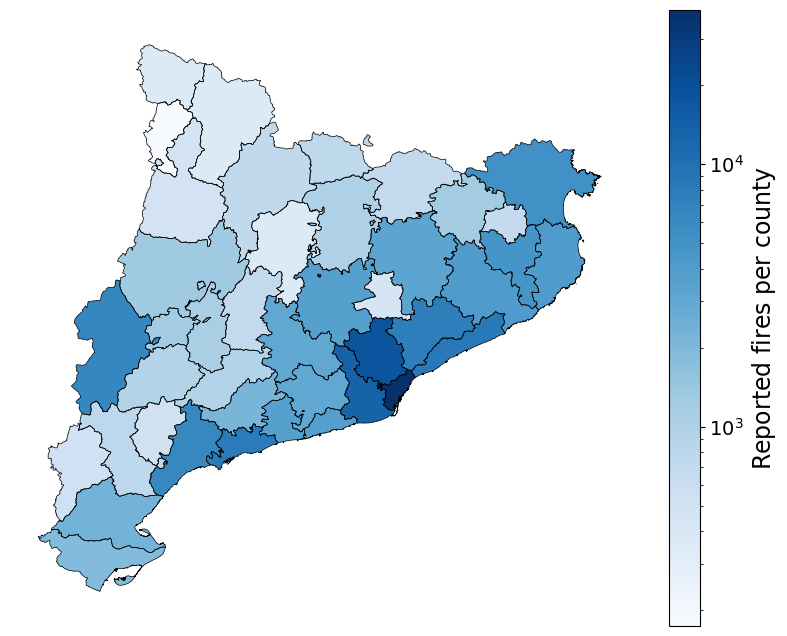

In [17]:
cat_regions = cat_comar
number_cat_regions = nincendis_comar
title_cat_regions_shp = 'NOMCOMAR'
title_cat_regions_pd = 'COMARCA'
number_label = '# incendis'
scale = LogNorm()
colorbar_type = "Blues"
colorbar_label = r'Reported fires per $\text{county}$'
ruta = fig_dir+"correlations/incendis_INFOCAT/nincendis-comar.pdf"

geographical_map(cat_regions,number_cat_regions,
                      title_cat_regions_shp, title_cat_regions_pd,
                      number_label, font, scale,
                      colorbar_type, colorbar_label, ruta)

### 2.1.2. Number of INFOCAT plans per catalonia regions

In [18]:
nINFOCAT_comar = INFOCAT.groupby('Comarca').size().reset_index(name='# INFOCAT plans')

We associate each county to the corresponding region.

In [19]:
comarques_prov = pd.DataFrame([])
comarques_prov["Comarca"] = INFOCAT["Comarca"]
comarques_prov["Província"] = INFOCAT["Província"]

comarques_prov.sort_values(by='Comarca', inplace=True)
comarques_prov.drop_duplicates(subset='Comarca', inplace=True)

nINFOCAT_comar["Província"] = comarques_prov["Província"].values

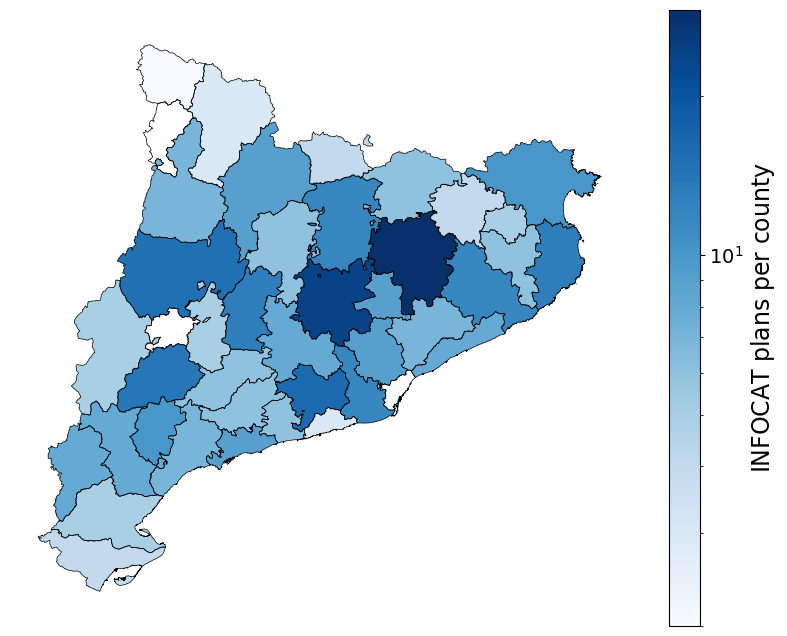

In [20]:
cat_regions = cat_comar
number_cat_regions = nINFOCAT_comar
title_cat_regions_shp = 'NOMCOMAR'
title_cat_regions_pd = 'Comarca'
number_label = '# INFOCAT plans'
scale = LogNorm() #scale = None
colorbar_type = "Blues"
colorbar_label = r'INFOCAT plans per $\text{county}$'
ruta = fig_dir+"correlations/incendis_INFOCAT/nINFOCAT-comar.pdf"

geographical_map(cat_regions,number_cat_regions,
                      title_cat_regions_shp, title_cat_regions_pd,
                      number_label, font, scale,
                      colorbar_type, colorbar_label, ruta)

### 2.1.3. Ratio of INFOCAT plans over fires per Catalonia regions

The ratio is defined as the quotient between the INFOCAT plans and the incidents.

In order to compute it per county, we must ensure there is data for all counties, but we realize that there are not INFOCAT plans in Pla d'Urgell & Alta Ribagorça, and that there are not registered fires in Lluçanès. Thus, we drop them from our dataframes:

In [21]:
nincendis_comar = nincendis_comar[(nincendis_comar["COMARCA"] != ("Pla d'Urgell")) & 
                                 (nincendis_comar["COMARCA"] != ("Alta Ribagorça"))].reset_index().drop("index",axis=1)

In [22]:
nINFOCAT_comar = nINFOCAT_comar[(nINFOCAT_comar["Comarca"] != ("Lluçanès"))].reset_index().drop("index",axis=1)

Now we can create the following DataFrame:

In [23]:
ratio_comar = pd.DataFrame([]) # incendis / # INFOCAT
ratio_comar["Comarca"] = nINFOCAT_comar["Comarca"]
ratio_comar["ratio"] = nincendis_comar["# incendis"] / nINFOCAT_comar["# INFOCAT plans"] #* (nINFOCAT_comar["# INFOCAT plans"].sum() / nincendis_comar["# incendis"].sum())

ratio_comar = ratio_comar[~ratio_comar.isin([np.inf, -np.inf]).any(axis=1)] # Drop any possible inf

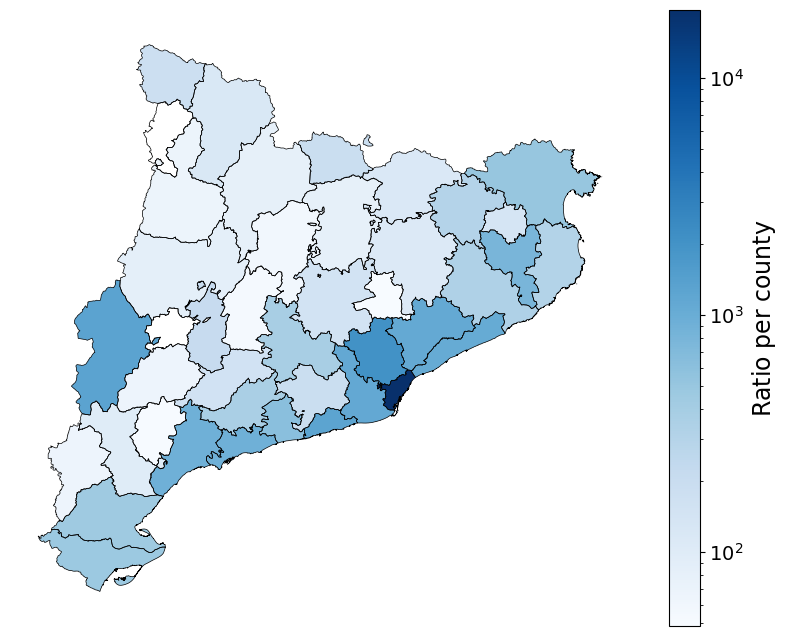

In [24]:
cat_regions = cat_comar
number_cat_regions = ratio_comar
title_cat_regions_shp = 'NOMCOMAR'
title_cat_regions_pd = 'Comarca'
number_label = 'ratio'
scale = LogNorm()
colorbar_type = "Blues"
colorbar_label = r'Ratio per $\text{county}$'
ruta = fig_dir+"correlations/incendis_INFOCAT/ratio-comar.pdf"

geographical_map(cat_regions,number_cat_regions,
                      title_cat_regions_shp, title_cat_regions_pd,
                      number_label, font, scale,
                      colorbar_type, colorbar_label, ruta)

## 2.2. Ratio & correlation <a class="anchor" id="2.2"></a>

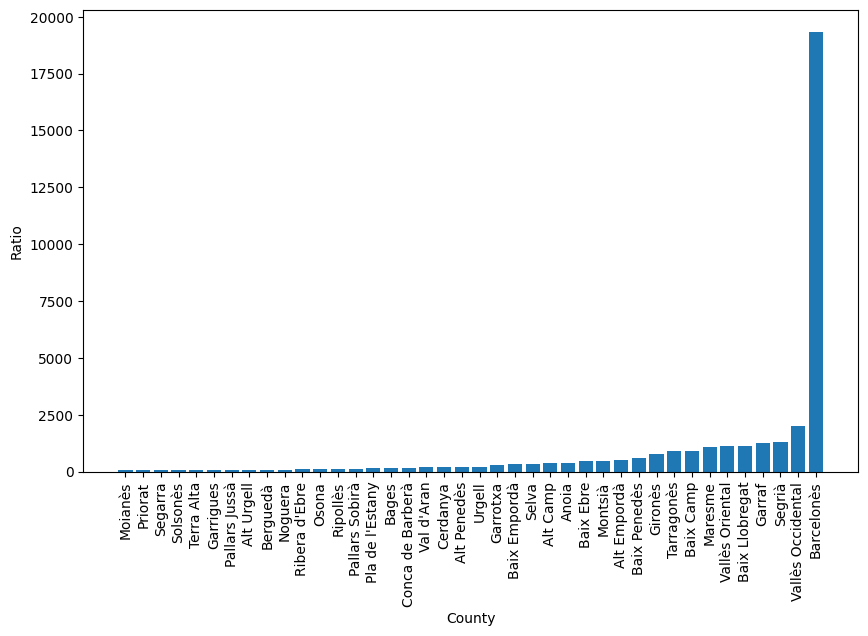

In [25]:
x = range(len(ratio_comar.sort_values(by="ratio"))) 

plt.figure(figsize=(10, 6))

# Graficar los datos con valores x enteros y asignar las etiquetas
plt.bar(x, ratio_comar.sort_values(by="ratio")["ratio"])

plt.xticks(x, ratio_comar.sort_values(by="ratio")["Comarca"], rotation = 90)  # Establecer las etiquetas del eje x

plt.xlabel('County')
plt.ylabel('Ratio')
#plt.title('Gráfico con Eje X de Strings')
plt.show()

We plot the distribution of ratios per county, without taking into account Barcelonés

In [26]:
ratio_bcn = ratio_comar[ratio_comar["Comarca"] != "Barcelonès"]

Text(0, 0.5, 'Frequency')

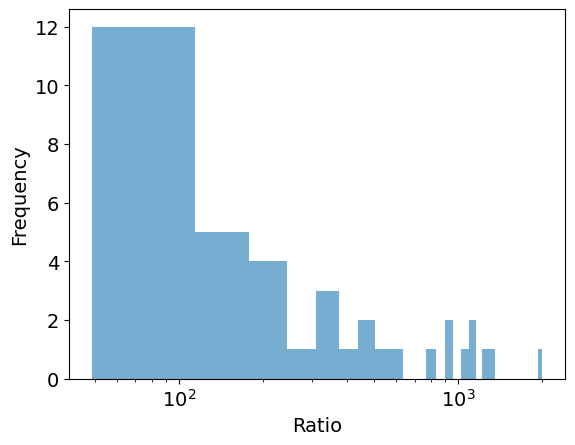

In [27]:
plt.hist(ratio_bcn["ratio"].values, bins=30,alpha=0.6)

plt.xticks(fontsize=font)
plt.yticks(fontsize=font)

plt.xscale("log")
plt.xlabel('Ratio', fontsize=font)
plt.ylabel('Frequency', fontsize=font)

And try to fit it with a Pareto dsitribution with the intern modul "curve_fit" of "scipy library".

In [28]:
from scipy.optimize import curve_fit

In [29]:
# Data normalized
data = ratio_bcn["ratio"].values / ratio_bcn["ratio"].sum()

# Histogram with data
hist, bin_edges = np.histogram(data, bins=30, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Paretto distribution
def pareto_distribution(x, alpha):
    
    pareto = (alpha / x) ** (alpha + 1)
    
    return pareto

# Fit the data with a curve of Pareto
params, cov = curve_fit(pareto_distribution, bin_centers, hist)

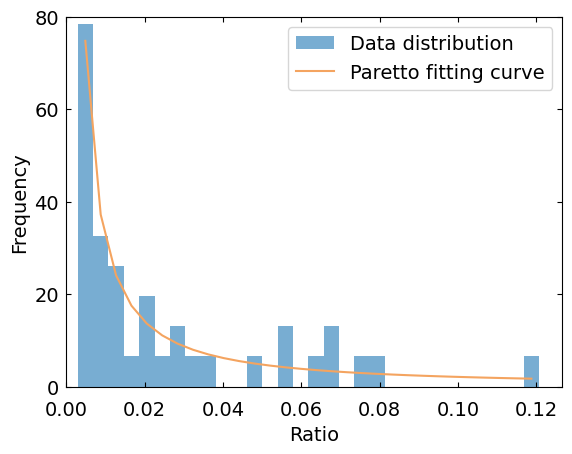

In [30]:
fig, ax = plt.subplots()


# Plot the histogram and the fitting curve
plt.hist(data, bins=30, density=True, alpha=0.6, label='Data distribution')
plt.plot(bin_centers, pareto_distribution(bin_centers, *params), color="sandybrown", label='Paretto fitting curve')

plt.xlabel('Ratio', fontsize=font)
plt.ylabel('Frequency', fontsize=font)

ax.tick_params(direction='in', which='both')
ax.tick_params(axis='x', which='both', top=True, bottom=True, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, pad=5)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

plt.xticks(fontsize=font)
plt.yticks([0,20,40,60,80],fontsize=font)

plt.xlim(0)
plt.ylim(0,80)
#plt.xscale("log")

plt.legend(fontsize=font)

ruta = fig_dir+"correlations/incendis_INFOCAT/ratio_distr-comar.pdf"
plt.savefig(ruta, dpi=500,bbox_inches='tight')

We now plot the number of fires over the INFOCAT plans. Each point correspond to a county, and we identify by clustering different regions.

In [31]:
correlation_comar = pd.DataFrame([])

correlation_comar["Província"] = nINFOCAT_comar["Província"]
correlation_comar["Comarca"] = nINFOCAT_comar["Comarca"]
correlation_comar["# incendis"] = nincendis_comar["# incendis"] 
correlation_comar["# INFOCAT plans"] = nINFOCAT_comar["# INFOCAT plans"]
correlation_comar["ratio"] = ratio_comar["ratio"]

In order to divide the samples per regions:

In [32]:
prov_name = ['Barcelona','Girona','Tarragona','Lleida']
prov_colors = ["violet","green","yellow","deepskyblue"]
prov_marker = ["o","s","^","*"]
prov_size = [50,42,60,90]

/var/folders/93/12z5kvyx445470bf3l70prdc0000gn/T/ipykernel_24079/3305630276.py:42: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,60)


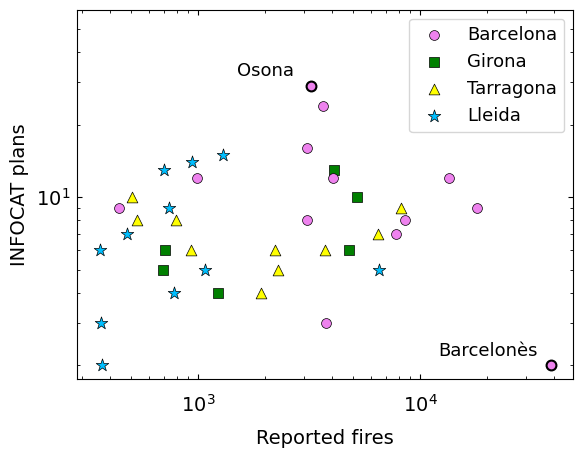

In [33]:
fig, ax = plt.subplots()

for i in range(correlation_comar.shape[0]):
    prov_i = correlation_comar["Província"][i]
    for j in range(0,len(prov_name)):
        if prov_name[j] == prov_i:
            plt.scatter(correlation_comar["# incendis"][i],correlation_comar["# INFOCAT plans"][i],
                        s=prov_size[j], color=prov_colors[j], marker = prov_marker[j], edgecolor='black', linewidth=0.5)

    if correlation_comar["Comarca"][i] == "Barcelonès":
        plt.scatter(correlation_comar["# incendis"][i],correlation_comar["# INFOCAT plans"][i],
                        s=prov_size[0], color=prov_colors[0], marker = prov_marker[0], edgecolor='black', linewidth=1.5)

    if correlation_comar["Comarca"][i] == "Osona":
        plt.scatter(correlation_comar["# incendis"][i],correlation_comar["# INFOCAT plans"][i],
                        s=prov_size[0], color=prov_colors[0], marker = prov_marker[0], edgecolor='black', linewidth=1.5)

   
ax.text(1.5*10**3,32, "Osona", fontsize = font-1)

ax.text(1.2*10**4,2.2, "Barcelonès", fontsize = font-1)

plt.xlabel('Reported fires', fontsize=font, labelpad=10)
plt.ylabel('INFOCAT plans', fontsize=font, labelpad=5)

plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
#plt.ylim(0,30)

plt.xticks(fontsize=font) 
plt.yticks(fontsize=font)

ax.tick_params(direction='in', which='both')
ax.tick_params(axis='x', which='both', top=True, bottom=True, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, pad=5)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylim(0,60)

# Llegenda
for i in range(0,len(prov_colors)):
        plt.scatter([],[], color=prov_colors[i], s=prov_size[i], marker = prov_marker[i], edgecolor='black', linewidth=0.5, label=prov_name[i])

plt.legend(loc='upper right', ncol=1, frameon=True, fontsize=font-1)

ruta = fig_dir+"correlations/incendis_INFOCAT/incendis_INFOCAT-corrleation_comar-prov.pdf"
plt.savefig(ruta, dpi=500,bbox_inches='tight')

We look for the counties that are outliers counties, where something strange is happening. On the one hand, the type 1 have a lof of INFOCAT plans activated. And, on the other hand, the type 2 will correspond to the less probable cases according to the Pareto distribution, so that they have the the largest ratios:


In [34]:
outliers_comar1 = correlation_comar.sort_values(by="# INFOCAT plans",ascending=False)[:2]["Comarca"].values
outliers_comar1

array(['Osona', 'Bages'], dtype=object)

In [35]:
outliers_comar2 = ratio_comar.sort_values(by="ratio",ascending=False)[:2]["Comarca"].values
outliers_comar2

array(['Barcelonès', 'Vallès Occidental'], dtype=object)

And we now try to get the counties in where the ratio is small:

In [36]:
good_comar = ratio_comar.sort_values(by="ratio",ascending=True)[:15]["Comarca"].values
good_comar

array(['Moianès', 'Priorat', 'Segarra', 'Solsonès', 'Terra Alta',
       'Garrigues', 'Pallars Jussà', 'Alt Urgell', 'Berguedà', 'Noguera',
       "Ribera d'Ebre", 'Osona', 'Ripollès', 'Pallars Sobirà',
       "Pla de l'Estany"], dtype=object)

We create a dataframe containing the other counties

In [37]:
correlation_comar_filt = correlation_comar.copy()

for j in range(0,len(outliers_comar2)):
    correlation_comar_filt = correlation_comar_filt[correlation_comar_filt["Comarca"] != outliers_comar2[j]]

for j in range(0,len(outliers_comar1)):
    correlation_comar_filt = correlation_comar_filt[correlation_comar_filt["Comarca"] != outliers_comar1[j]]

for j in range(0,len(good_comar)):
    correlation_comar_filt = correlation_comar_filt[correlation_comar_filt["Comarca"] != good_comar[j]]

correlation_comar_filt = correlation_comar_filt.reset_index().drop("index",axis=1)

In [38]:
corr_coef_comar = np.corrcoef(correlation_comar_filt["# incendis"],correlation_comar_filt["# INFOCAT plans"])[0][1]

And we plot all them, making a regression with the counties selected (if considered)

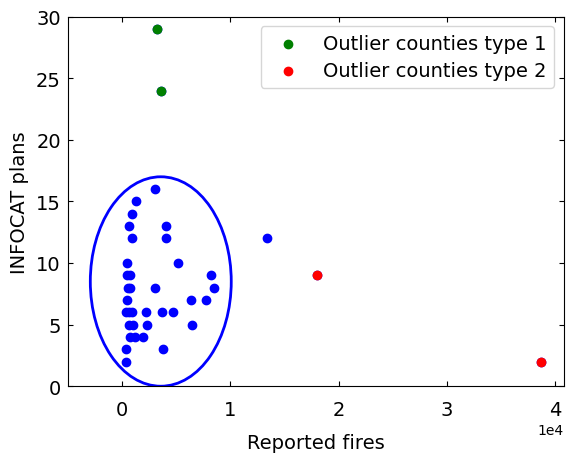

In [39]:
fig, ax = plt.subplots()

for i in range(correlation_comar.shape[0]):

    plt.scatter(correlation_comar["# incendis"][i],correlation_comar["# INFOCAT plans"][i], color="blue")

    #for j in range(0,len(good_comar)):
     #   if correlation_comar["Comarca"][i] == good_comar[j]:
      #      plt.scatter(correlation_comar["# incendis"][i],correlation_comar["# INFOCAT plans"][i], color="orange")
   
    for j in range(0,len(outliers_comar1)):
        if correlation_comar["Comarca"][i] == outliers_comar1[j]:
            plt.scatter(correlation_comar["# incendis"][i],correlation_comar["# INFOCAT plans"][i], color="green")
     
    for j in range(0,len(outliers_comar2)):
        if correlation_comar["Comarca"][i] == outliers_comar2[j]:
            plt.scatter(correlation_comar["# incendis"][i],correlation_comar["# INFOCAT plans"][i], color="red")
   

#sns.regplot(x='# incendis', y='# INFOCAT plans', data=correlation_comar_filt, scatter=True, color="blue")
#ax.text(2.5*10**4,15, "Correlation: %0.2f" % corr_coef_comar, fontsize = font)

plt.xlabel('Reported fires', fontsize=font, labelpad=10)
plt.ylabel('INFOCAT plans', fontsize=font, labelpad=5)

plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ylim(0,30)

plt.xticks(fontsize=font) 
plt.yticks(fontsize=font)

ax.tick_params(direction='in', which='both')
ax.tick_params(axis='x', which='both', top=True, bottom=True, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, pad=5)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

# Ellipses
elipse_1 = Ellipse(xy=(0.36*10**4, 8.5), width=1.3*10**4, height=17, edgecolor='blue', fc='None', lw=2, angle=0)
ax.add_patch(elipse_1)

plt.scatter([],[],color="green", label = "Outlier counties type 1")
plt.scatter([],[],color="red", label = "Outlier counties type 2")
#plt.scatter([],[],color="orange", label = "Less ratio counties")

plt.legend(loc='upper right', ncol=1, labelspacing=0.4, frameon=True, fontsize=font)
              
ruta = fig_dir+"correlations/incendis_INFOCAT/incendis_INFOCAT-correlation_comar.pdf"
plt.savefig(ruta, dpi=500,bbox_inches='tight')

## 2.3. Temporal evolution <a class="anchor" id="2.3"></a>

We append a feature containing the year of each sample for both datasets.

In [40]:
incendis["year"] = incendis['datetime'].dt.year
INFOCAT["year"] = INFOCAT["Data de l'últim esdeveniment"].dt.year

We pay attention on the temporal evolution for Barcelonès and Osona counties

In [41]:
nincendis_time = incendis[incendis["COMARCA"] == "Osona"].groupby("year")['INCIDENTS'].sum().reset_index(name = "#")
nINFOCAT_time = INFOCAT[INFOCAT["Comarca"] == "Osona"].groupby("year").size().reset_index(name="#")

nincendis_time["type"] = "Reported fires"
nINFOCAT_time["type"] = "INFOCAT plans"

In [42]:
n_time = pd.concat([nincendis_time,nINFOCAT_time])
n_time

,year,#,type
0,2018,491,Reported fires
1,2019,773,Reported fires
2,2020,526,Reported fires
3,2021,669,Reported fires
4,2022,750,Reported fires
0,2018,8,INFOCAT plans
1,2019,7,INFOCAT plans
2,2020,9,INFOCAT plans
3,2021,3,INFOCAT plans
4,2022,2,INFOCAT plans


Text(0.5, 1.0, 'Osona')

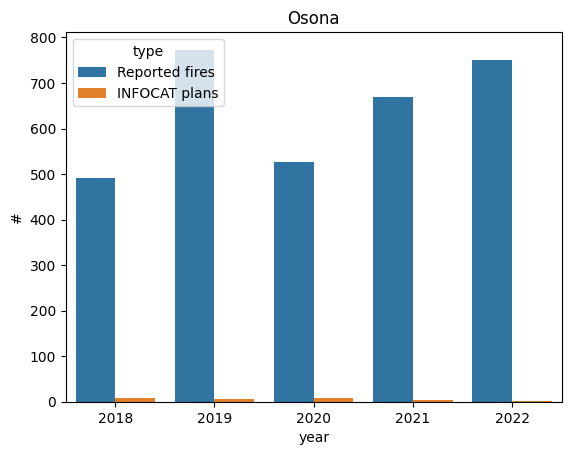

In [43]:
sns.barplot(data=n_time,  x="year",y="#", hue="type", dodge=True)
plt.title("Osona")

In [44]:
nincendis_time = incendis[incendis["COMARCA"] == "Barcelonès"].groupby("year")['INCIDENTS'].sum().reset_index(name = "#")
nINFOCAT_time = INFOCAT[INFOCAT["Comarca"] == "Barcelonès"].groupby("year").size().reset_index(name="#")

nincendis_time["type"] = "Reported fires"
nINFOCAT_time["type"] = "INFOCAT plans"

In [45]:
n_time = pd.concat([nincendis_time,nINFOCAT_time])
n_time

,year,#,type
0,2018,6865,Reported fires
1,2019,7850,Reported fires
2,2020,6158,Reported fires
3,2021,8522,Reported fires
4,2022,9295,Reported fires
0,2021,1,INFOCAT plans
1,2022,1,INFOCAT plans


Text(0.5, 1.0, 'Barcelonès')

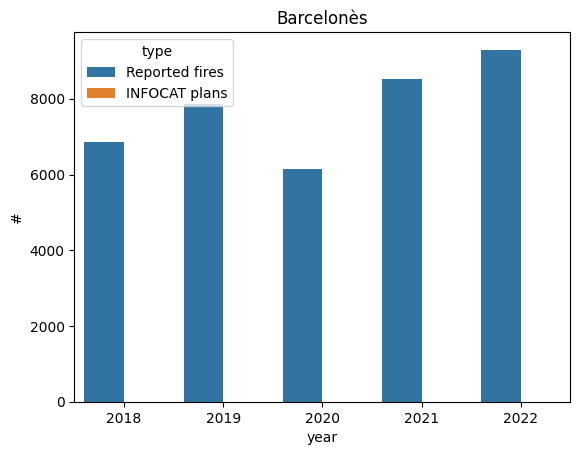

In [46]:
sns.barplot(data=n_time,  x="year",y="#", hue="type", dodge=True)
plt.title("Barcelonès")

We group the number of fires and INFOCAT plans per month.

In [47]:
inc_112_df = incendis
inc_112_label = '# incendis'

nincendis_time = inc_112_temporal_ev(inc_112_df,inc_112_label)
nincendis_time.head()

,# incendis,datetime
0,2954,2018-01-01
1,2358,2018-02-01
2,2485,2018-03-01
3,1881,2018-04-01
4,1970,2018-05-01


In [48]:
prot_plan_df = INFOCAT
prot_plan_label = "# INFOCAT plans"

nINFOCAT_time = prot_plans_temporal_ev(prot_plan_df,prot_plan_label)
nINFOCAT_time

,# INFOCAT plans,datetime
0,82,2018-12-01
1,28,2019-03-01
2,17,2019-06-01
3,1,2019-07-01
4,6,2019-09-01
5,21,2020-02-01
6,24,2020-10-01
7,9,2020-12-01
8,91,2021-12-01
9,25,2022-03-01


But we realize that the data from INFOCAT plans is not collected every month. Thus, in order to compare the number of INFOCAT plans and fires, we must group the fires in the time intervals given by the INFOCAT plans.

In [49]:
nincendis_time2 = nINFOCAT_time.copy()
nincendis_time2["# incendis"] = nincendis_time2["# INFOCAT plans"]
nincendis_time2 = nincendis_time2.drop("# INFOCAT plans",axis=1)

In [50]:
nincendis_time2["# incendis"][0] = nincendis_time[nincendis_time["datetime"] <= nINFOCAT_time["datetime"][0]]["# incendis"].sum()

for i in range(1,nincendis_time2.shape[0]-1):
    nincendis_time2["# incendis"][i] = nincendis_time[(nincendis_time["datetime"] > nINFOCAT_time["datetime"][i-1])
                                                     &(nincendis_time["datetime"] <= nINFOCAT_time["datetime"][i])]["# incendis"].sum()
    
nincendis_time2

/var/folders/93/12z5kvyx445470bf3l70prdc0000gn/T/ipykernel_24079/683849286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nincendis_time2["# incendis"][0] = nincendis_time[nincendis_time["datetime"] <= nINFOCAT_time["datetime"][0]]["# incendis"].sum()
/var/folders/93/12z5kvyx445470bf3l70prdc0000gn/T/ipykernel_24079/683849286.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nincendis_time2["# incendis"][i] = nincendis_time[(nincendis_time["datetime"] > nINFOCAT_time["datetime"][i-1])
/var/folders/93/12z5kvyx445470bf3l70prdc0000gn/T/ipykernel_24079/683849286.py:4: SettingWithCopyWarning: 
A value is trying to be 

,datetime,# incendis
0,2018-12-01,29577
1,2019-03-01,8604
2,2019-06-01,9437
3,2019-07-01,3400
4,2019-09-01,5191
5,2020-02-01,14446
6,2020-10-01,18285
7,2020-12-01,4706
8,2021-12-01,35721
9,2022-03-01,9392


Since the code is well done, we can now plot the time evolution of each variable and compare them.

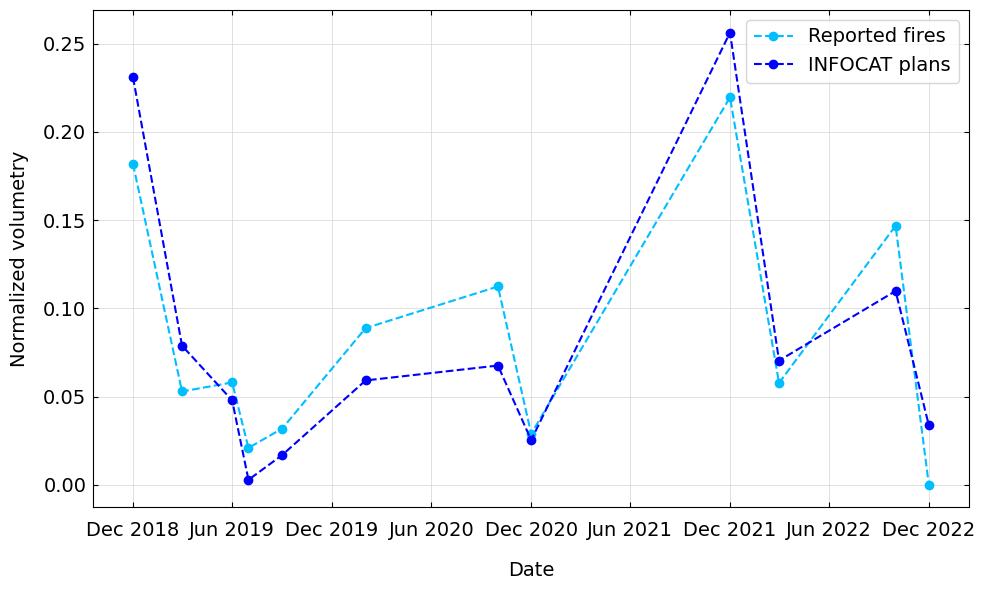

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(nincendis_time2['datetime'], nincendis_time2['# incendis'] / nincendis_time2['# incendis'].sum(), marker='o', linestyle='--', color='deepskyblue', label="Reported fires")
plt.plot(nINFOCAT_time['datetime'], nINFOCAT_time['# INFOCAT plans'] / nINFOCAT_time['# INFOCAT plans'].sum() , marker='o', linestyle='--', color='blue', label="INFOCAT plans")


ax.tick_params(direction='in', which='both')
ax.tick_params(axis='x', which='both', top=True, bottom=True, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, pad=5)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

plt.xlabel('Date', fontsize=font, labelpad=15)
plt.ylabel('Normalized volumetry', fontsize=font, labelpad=10)

# Month & year in the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.xticks(["2018-12","2019-06","2019-12","2020-06","2020-12","2021-06","2021-12","2022-06","2022-12"], rotation=0, fontsize=font) 
plt.yticks(fontsize=font)
    
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)

plt.tight_layout()

plt.legend(loc="upper right",fontsize=font)

ruta = fig_dir+"correlations/incendis_INFOCAT/incendis_INFOCAT-temporal_evolution.pdf"
plt.savefig(ruta, dpi=500,bbox_inches='tight')

In [52]:
correlation_time = pd.DataFrame([])

correlation_time["# incendis"] = nincendis_time2["# incendis"] 
correlation_time["# INFOCAT plans"] = nINFOCAT_time["# INFOCAT plans"]

In [53]:
corr_matrix_time = correlation_time.corr()
corr_coef_time = correlation_time.corr().values[0][1]

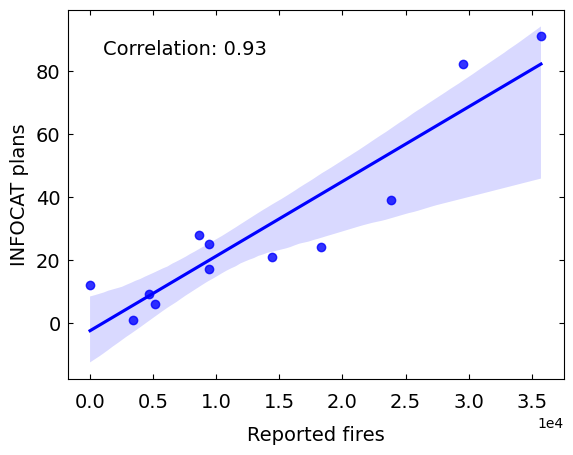

In [54]:
fig, ax = plt.subplots()

sns.regplot(x='# incendis', y='# INFOCAT plans', data=correlation_time, scatter=True, fit_reg=False, color="blue")
sns.regplot(x='# incendis', y='# INFOCAT plans', data=correlation_time, scatter=False, line_kws={"color": "blue"})

plt.xlabel('Reported fires', fontsize=font, labelpad=10)
plt.ylabel('INFOCAT plans', fontsize=font, labelpad=5)

plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.xticks(fontsize=font) 
plt.yticks(fontsize=font)

ax.tick_params(direction='in', which='both')
ax.tick_params(axis='x', which='both', top=True, bottom=True, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, pad=5)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.text(0.1*10**4,85, "Correlation: %0.2f" % corr_coef_time, fontsize = font)

ruta = fig_dir+"correlations/incendis_INFOCAT/incendis_INFOCAT-correlation_time.pdf"
plt.savefig(ruta, dpi=500,bbox_inches='tight')

# 3. Meteorology vs VENTCAT, INUNCAT <a class="anchor" id="3"></a>

In [55]:
VENTCAT = protection_plans[(protection_plans["Nom del pla"] == "PAM VENTCAT")].drop("Unnamed: 0",axis=1)
INUNCAT = protection_plans[(protection_plans["Nom del pla"] == "PAM INUNCAT")].drop("Unnamed: 0",axis=1)

METEOCAT = pd.concat([VENTCAT,INUNCAT])
METEOCAT

,Tipus pla,Nom del pla,Últim esdeveniment,Data de l'últim esdeveniment,Municipi,Comarca,Província
16,E,PAM VENTCAT,Homologació,2018-12-05,Torroella de Montgrí,Baix Empordà,Girona
23,E,PAM VENTCAT,Homologació,2018-12-05,Preses,Garrotxa,Girona
36,E,PAM VENTCAT,Homologació,2018-12-05,Vilanova de Sau,Osona,Barcelona
39,E,PAM VENTCAT,Homologació,2018-12-05,Ponts,Noguera,Lleida
43,E,PAM VENTCAT,Homologació,2018-12-05,Begur,Baix Empordà,Girona
...,...,...,...,...,...,...,...
1986,E,PAM INUNCAT,Revisió,2022-12-15,Tarroja de Segarra,Segarra,Lleida
1988,E,PAM INUNCAT,Revisió,2022-12-15,Cervera,Segarra,Lleida
1992,E,PAM INUNCAT,Homologació,2022-12-15,Estamariu,Alt Urgell,Lleida
1993,E,PAM INUNCAT,Homologació,2022-12-15,Sant Joan Despí,Baix Llobregat,Barcelona


In [56]:
meteo = inc_112[(inc_112["TIPUS"] == "Meteorologia")].reset_index().drop("index",axis=1).drop("Unnamed: 0",axis=1)
meteo

,PROVINCIA,COMARCA,MUNICIPI,TIPUS,INCIDENTS,datetime
0,Barcelona,Baix Llobregat,ESPLUGUES DE LLOBREGAT,Meteorologia,1,2018-01-01
1,Tarragona,Tarragonès,TORREDEMBARRA,Meteorologia,1,2018-01-01
2,Girona,Cerdanya,PUIGCERDA,Meteorologia,1,2018-01-01
3,Tarragona,Tarragonès,VILALLONGA DEL CAMP,Meteorologia,1,2018-01-01
4,Girona,Ripollès,SANT JOAN DE LES ABADESSES,Meteorologia,1,2018-01-01
...,...,...,...,...,...,...
5596,Lleida,Noguera,ARTESA DE SEGRE,Meteorologia,1,2022-12-01
5597,Barcelona,Bages,MONISTROL DE MONTSERRAT,Meteorologia,1,2022-12-01
5598,Tarragona,Baix Camp,VANDELLOS I L'HOSPITALET DE L'INFANT,Meteorologia,1,2022-12-01
5599,Barcelona,Baix Llobregat,ESPLUGUES DE LLOBREGAT,Meteorologia,1,2022-12-01


# 4. Assistència sanitària vs SISMICAT, ALLAUCAT, INUNCAT, VENTCAT, INFOCAT <a class="anchor" id="4"></a>

In [57]:
ALLAUCAT = protection_plans[(protection_plans["Nom del pla"] == "PAM ALLAUCAT")]
SISMICAT = protection_plans[(protection_plans["Nom del pla"] == "PAM SISMICAT")]
VENTCAT = protection_plans[(protection_plans["Nom del pla"] == "PAM VENTCAT")]
INUNCAT = protection_plans[(protection_plans["Nom del pla"] == "PAM INUNCAT")]

SANICAT = pd.concat([ALLAUCAT,SISMICAT,VENTCAT,INUNCAT]).drop("Unnamed: 0",axis=1)
SANICAT

,Tipus pla,Nom del pla,Últim esdeveniment,Data de l'últim esdeveniment,Municipi,Comarca,Província
2,E,PAM ALLAUCAT,Homologació,2018-12-05,Arres,Val d'Aran,Lleida
29,E,PAM ALLAUCAT,Homologació,2018-12-05,Bòrdes,Val d'Aran,Lleida
198,E,PAM ALLAUCAT,Homologació,2018-12-05,Guardiola de Berguedà,Berguedà,Barcelona
218,E,PAM ALLAUCAT,Homologació,2018-12-05,Vielha e Mijaran,Val d'Aran,Lleida
222,E,PAM ALLAUCAT,Homologació,2018-12-05,Josa i Tuixén,Alt Urgell,Lleida
...,...,...,...,...,...,...,...
1986,E,PAM INUNCAT,Revisió,2022-12-15,Tarroja de Segarra,Segarra,Lleida
1988,E,PAM INUNCAT,Revisió,2022-12-15,Cervera,Segarra,Lleida
1992,E,PAM INUNCAT,Homologació,2022-12-15,Estamariu,Alt Urgell,Lleida
1993,E,PAM INUNCAT,Homologació,2022-12-15,Sant Joan Despí,Baix Llobregat,Barcelona


In [58]:
sanitaria = inc_112[(inc_112["TIPUS"] == "Assistència sanitària")].reset_index().drop("index",axis=1).drop("Unnamed: 0",axis=1)
sanitaria

,PROVINCIA,COMARCA,MUNICIPI,TIPUS,INCIDENTS,datetime
0,Barcelona,Anoia,ODENA,Assistència sanitària,21,2018-01-01
1,Barcelona,Osona,TONA,Assistència sanitària,21,2018-01-01
2,Girona,Garrotxa,BESALU,Assistència sanitària,7,2018-01-01
3,Girona,Garrotxa,MIERES,Assistència sanitària,1,2018-01-01
4,Lleida,Segrià,ALCOLETGE,Assistència sanitària,11,2018-01-01
...,...,...,...,...,...,...
45621,Tarragona,Tarragonès,LA CANONJA,Assistència sanitària,49,2022-12-01
45622,Lleida,Garrigues,LA GRANADELLA,Assistència sanitària,2,2022-12-01
45623,Barcelona,Alt Penedès,PACS DEL PENEDES,Assistència sanitària,3,2022-12-01
45624,Tarragona,Priorat,LA FIGUERA,Assistència sanitària,2,2022-12-01
